# ARID1A proteomics cis comparison

## Step 1: Library Imports

Run this cell to import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import sys 
sys.path.append('C:\\Users\\brittany henderson\\GitHub\\WhenMutationsMatter\\Brittany\\')
import functions as f

import cptac
import cptac.algorithms as al

## Step 2: Find the frequently mutated genes for Endometrial Cancer

Enter the type of cancer and the cutoff for mutation frequency that you would like to use.

In [2]:
en_object = cptac.Endometrial()
desired_cutoff = .1

endometrial_freq_mut = al.get_frequently_mutated(en_object, cutoff=desired_cutoff)
print('\n\nNumber of Frequently Mutated Genes:', len(endometrial_freq_mut), '\n', endometrial_freq_mut.head())

                                    

Number of Frequently Mutated Genes: 232 
         Unique_Samples_Mut  Missence_Mut  Truncation_Mut
Gene                                                    
ABCA12            0.147368      0.094737        0.073684
ABCA13            0.115789      0.105263        0.042105
ACVR2A            0.105263      0.010526        0.094737
ADGRG4            0.136842      0.126316        0.021053
ADGRV1            0.115789      0.094737        0.052632


## Step 3: Select a gene from the list of frequently mutated genes above

Set the gene to which of the above frequently mutated genes you want to examine. For example, if you want to look at the gene PTEN, change the cell below to say "gene = 'KRAS'"

In [3]:
gene = 'ARID1A'

## Step 4: Select desired omics comparison

Select which type of omics you want to compare. If you want to compare proteomics data for the interacting proteins, uncomment the "omics = en.get_proteomics()" line, etc.

In [4]:
omics = en_object.get_proteomics()
#omics = en_object.get_transcriptomics()
#omics = en_object.get_phosphoproteomics()
#omics = en_object.get_acetylproteomics()

## Step 5: cis comparison 

Determine if the DNA mutation has an effect on the omics measurement. In order to do this, we have a few steps in code. These steps are found in the format_cis_comparison_data function.
1. get a table with both the omics and mutation data for tumors
2. get a binary column from the mutation data to separate our samples
3. format data frame to be used in the T-test
4. send data to the T-test.

The format_cis_comparison_data does the first 3 steps.

In [5]:
compare_mut_wt = f.format_cis_comparison_data(en_object, omics, 'proteomics', gene)

compare_mut_wt.head()

,ARID1A_proteomics,binary_mutations
Sample_ID,,
S001,-0.8790,Mutated
S002,-1.4100,Mutated
S003,-1.0400,Wildtype
S005,0.3850,Wildtype
S006,0.0106,Wildtype


In [6]:
omics_col_list = ['ARID1A_proteomics']

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison\n")
significant_pval_results = al.wrap_ttest(compare_mut_wt, 'binary_mutations', omics_col_list)
print(significant_pval_results)

Doing t-test comparison

          Comparison       P_Value
0  ARID1A_proteomics  1.025018e-10


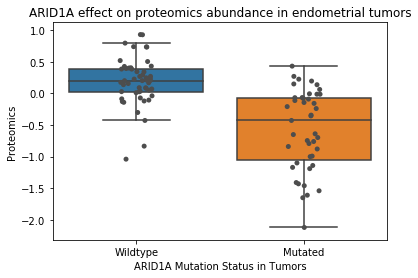

In [7]:
# Step 5 - Create boxplt to compare wildtype and mutated effect on omics data
en_cis_boxplot = sns.boxplot(data = compare_mut_wt, x = 'binary_mutations',
                          y = 'ARID1A_proteomics', order = ["Wildtype","Mutated"], showfliers = False)  
en_cis_boxplot.set_title(gene + " effect on " + 'proteomics' + " abundance in endometrial tumors")
en_cis_boxplot = sns.stripplot(data= compare_mut_wt, x = 'binary_mutations',
                            y = 'ARID1A_proteomics',jitter = True, color = ".3", order = ["Wildtype","Mutated"])
en_cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
plt.show()

In [8]:
mutation_type_comparison = f.get_missence_truncation_comparison(en_object, omics, 'proteomics', gene)
#print(mutation_type_comparison.head())

# T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison\n")
significant_pval_results = al.wrap_ttest(mutation_type_comparison, 'binary_mutations', omics_col_list)
print(significant_pval_results)

Doing t-test comparison

No significant comparisons.
None


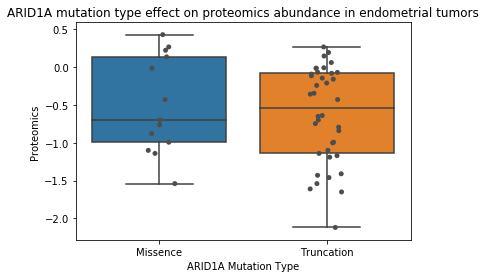

In [9]:
# Step 5 - Create boxplt to compare mutation type effect on omics data
en_cis_boxplot = sns.boxplot(data = mutation_type_comparison, x = 'binary_mutations',
                          y = 'ARID1A_proteomics', order = ["Missence","Truncation"], showfliers = False)  
en_cis_boxplot.set_title(gene + " mutation type effect on proteomics abundance in endometrial tumors")
en_cis_boxplot = sns.stripplot(data= mutation_type_comparison, x = 'binary_mutations',
                            y = 'ARID1A_proteomics',jitter = True, color = ".3", order = ["Missence","Truncation"])
en_cis_boxplot.set(xlabel = gene + " Mutation Type", ylabel = 'Proteomics')
plt.show()

# Repeat with the Colon dataset

Go through the same process, this time using the Colon dataset. We will only print five genes from the frequently mutated data frame for simplicity.

In [10]:
colon_object = cptac.Colon()
desired_cutoff = .1

colon_freq_mut = al.get_frequently_mutated(colon_object, cutoff=desired_cutoff)
print('\n\nNumber of Frequently Mutated Genes:', len(colon_freq_mut), '\n', colon_freq_mut.head())

                                    

Number of Frequently Mutated Genes: 612 
         Unique_Samples_Mut  Missence_Mut  Truncation_Mut
Gene                                                    
ABCA13            0.195876      0.164948        0.103093
ABCA2             0.175258      0.164948        0.030928
ABCA4             0.144330      0.082474        0.061856
ABCB4             0.134021      0.061856        0.072165
ABCB6             0.103093      0.061856        0.041237


In [11]:
gene = 'ARID1A'

co_omics = colon_object.get_proteomics()
#co_omics = colon_object.get_transcriptomics()
#co_omics = colon_object.get_phosphoproteomics()
#co_omics = colon_object.get_acetylproteomics()

In [12]:
co_data_for_comparison = f.format_cis_comparison_data(colon_object, co_omics, 'proteomics', gene)
#co_data_for_comparison.head()

print("Doing t-test comparison\n")
significant_pval_results = al.wrap_ttest(co_data_for_comparison, 'binary_mutations', omics_col_list)
print(significant_pval_results)

Doing t-test comparison

          Comparison   P_Value
0  ARID1A_proteomics  0.001305


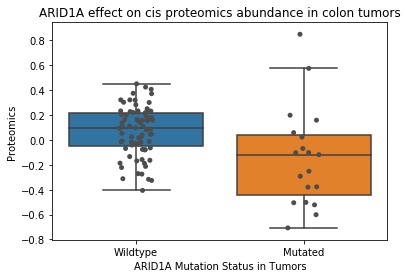

In [13]:
cis_boxplot = sns.boxplot(data = co_data_for_comparison, x = 'binary_mutations',
                          y = 'ARID1A_proteomics', order = ["Wildtype","Mutated"], showfliers = False)  
cis_boxplot.set_title(gene + " effect on cis proteomics abundance in colon tumors")
cis_boxplot = sns.stripplot(data = co_data_for_comparison, x = 'binary_mutations',
                            y = 'ARID1A_proteomics', jitter = True, color = ".3", 
                            order = ["Wildtype","Mutated"])
cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
plt.show()

In [14]:
co_mutation_type_comparison = f.get_missence_truncation_comparison(colon_object, co_omics, 'proteomics', gene)

print("Doing t-test comparison\n")
significant_pval_results = al.wrap_ttest(co_mutation_type_comparison, 'binary_mutations', omics_col_list)
print(significant_pval_results)

Doing t-test comparison

No significant comparisons.
None


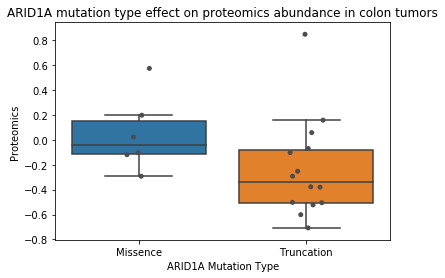

In [15]:

co_cis_boxplot = sns.boxplot(data = co_mutation_type_comparison, x = 'binary_mutations',
                          y = 'ARID1A_proteomics', order = ["Missence","Truncation"], showfliers = False)  
co_cis_boxplot.set_title(gene + " mutation type effect on proteomics abundance in colon tumors")
co_cis_boxplot = sns.stripplot(data= co_mutation_type_comparison, x = 'binary_mutations',
                            y = 'ARID1A_proteomics',jitter = True, color = ".3", order = ["Missence","Truncation"])
co_cis_boxplot.set(xlabel = gene + " Mutation Type", ylabel = 'Proteomics')
plt.show()

# Repeat with the Ovarian dataset


In [16]:
ovarian_object = cptac.Ovarian()
desired_cutoff = .1

ovarian_freq_mut = al.get_frequently_mutated(ovarian_object, cutoff=desired_cutoff)

In [17]:
gene = 'ARID1A'

ov_omics = ovarian_object.get_proteomics()
#ov_omics = ovarian_object.get_transcriptomics()
#ov_omics = ovarian_object.get_phosphoproteomics()
#ov_omics = ovarian_object.get_acetylproteomics()

In [18]:
ov_data_for_comparison = f.format_cis_comparison_data(ovarian_object, ov_omics, 'proteomics', gene)

omics_col_list = ['ARID1A_proteomics']

print("Doing t-test comparison\n")
significant_pval_results = al.wrap_ttest(ov_data_for_comparison, 'binary_mutations', omics_col_list)
print(significant_pval_results)

Doing t-test comparison

No significant comparisons.
None


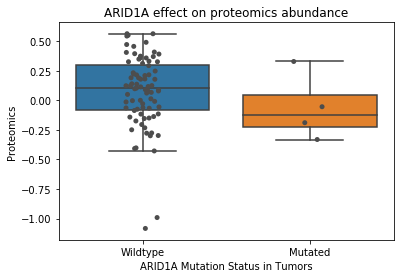

In [19]:
# Step 5 - Visualize comparison
ov_cis_boxplot = sns.boxplot(data = ov_data_for_comparison, x = 'binary_mutations',
                          y = 'ARID1A_proteomics', order = ["Wildtype","Mutated"], showfliers = False)  
ov_cis_boxplot.set_title(gene + " effect on proteomics abundance")
ov_cis_boxplot = sns.stripplot(
    data = ov_data_for_comparison, x = 'binary_mutations',y = 'ARID1A_proteomics', 
    jitter = True, color = ".3", order = ["Wildtype","Mutated"])
ov_cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
plt.show()

fig = ov_cis_boxplot.get_figure()
plt.show()
fig.savefig('ARID1A_figures.png', bbox_inches = 'tight')

Doing t-test comparison

No significant comparisons.
None


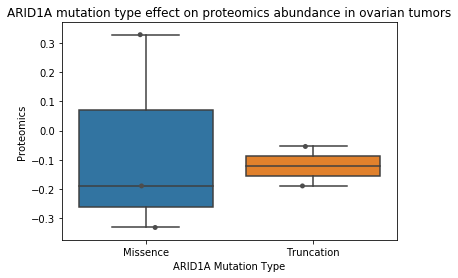

In [20]:
ov_mutation_type_comparison = f.get_missence_truncation_comparison(ovarian_object, ov_omics, 'proteomics', gene)

print("Doing t-test comparison\n")
significant_pval_results = al.wrap_ttest(ov_mutation_type_comparison, 'binary_mutations', omics_col_list)
print(significant_pval_results)

# Step 5 - Create boxplt to compare mutation type effect on omics data
ov_cis_boxplot = sns.boxplot(data = ov_mutation_type_comparison, x = 'binary_mutations',
                          y = 'ARID1A_proteomics', order = ["Missence","Truncation"], showfliers = False)  
ov_cis_boxplot.set_title(gene + " mutation type effect on proteomics abundance in ovarian tumors")
ov_cis_boxplot = sns.stripplot(data= ov_mutation_type_comparison, x = 'binary_mutations',
                            y = 'ARID1A_proteomics',jitter = True, color = ".3", order = ["Missence","Truncation"])
ov_cis_boxplot.set(xlabel = gene + " Mutation Type", ylabel = 'Proteomics')

fig = ov_cis_boxplot.get_figure()
plt.show()
fig.savefig('ARID1A_figures.png', bbox_inches = 'tight')

In [21]:
fig = ov_cis_boxplot.get_figure()
plt.show()

AttributeError: 'AxesSubplot' object has no attribute 'get'

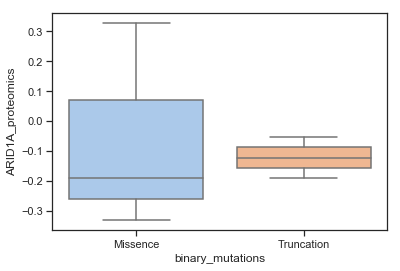

In [22]:
sns.set(style="ticks", palette="pastel")

# Draw a nested boxplot to show bills by day and time
sns.boxplot(data = ov_mutation_type_comparison, x = 'binary_mutations',
                    y = 'ARID1A_proteomics', order = ["Missence","Truncation"], showfliers = False)
sns.boxplot(data = co_cis_boxplot, x = 'binary_mutations',
                          y = 'ARID1A_proteomics', order = ["Missence","Truncation"], showfliers = False)
sns.boxplot(data = en_cis_boxplot, x = 'binary_mutations',
                          y = 'ARID1A_proteomics', order = ["Missence","Truncation"], showfliers = False)
sns.despine(offset=10, trim=True)

In [ ]:
from IPython.display import Image
Image('ov_mut_status.png')

from IPython.display import Image
Image('ARID1A_figures.png')
